In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.mplot3d.art3d as art3d

import pandas as pd

import yaml
import raddetect as rd

In [ ]:
# For running in VSCode, add this line and adjust to your local path of the repository
import os
# os.chdir("/home/USER/PATH_TO_REPO/RadDetect/tutorials/")

In [2]:
# Example of loading the YAML configurations and creating an instance of the class
with open('../utility/226_radium.yml', 'r') as file:
    ion_config = yaml.safe_load(file)

with open('../utility/monalpha_configuration.yml', 'r') as file:
    detector_settings = yaml.safe_load(file)

FileNotFoundError: [Errno 2] No such file or directory: '../utility/226_radium.yml'

### Computing gemotrical efficiciency

In [4]:
eff = rd.monalpha.MonAlphaDetectorGeometricalEfficiency(detector_settings)
eff.run_simulation()

Detection Efficiency: 22.17%
Simulation complete.


Diode shape:  square
Implantation profile:  point
Activity shape:  round


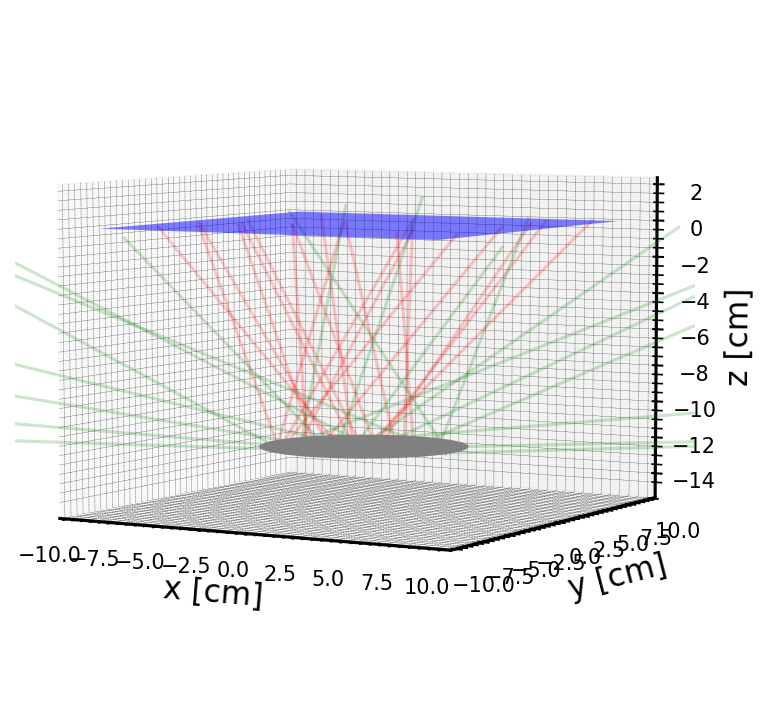

In [156]:
"""_positions = eff.generate_positions()
_directions = eff.generate_directions()
_intersections = eff.calculate_intersections(_positions, _directions)"""

print('Diode shape: ', eff.DIODE_SHAPE)
print('Implantation profile: ', eff.IMP_DISTR)
print('Activity shape: ', eff.ACT_SHAPE)

# xx, yy = np.meshgrid(np.arange(-eff.DIODE_SIZE/2, eff.DIODE_SIZE/2),
#                 np.arange(-eff.DIODE_SIZE/2, eff.DIODE_SIZE/2)
#                 )
# zz = eff.DIST_SAMP_DIODE + 0*xx + 0*yy 
# ax.plot_surface(xx, yy, zz, alpha=0.2)

fig = plt.figure(figsize=(6, 6), dpi=150)
ax = fig.add_subplot(111,projection='3d')


art3d.pathpatch_2d_to_3d(ax.add_patch(mpl.patches.Rectangle((-eff.DIODE_SIZE/2, -eff.DIODE_SIZE/2), eff.DIODE_SIZE, eff.DIODE_SIZE,
                                                        facecolor='blue', alpha = 0.5)), z = 0, zdir="z")
art3d.pathpatch_2d_to_3d(ax.add_patch(mpl.patches.Circle((0, 0), eff.ACT_EXT, facecolor='grey', alpha = 1)), 
                         z=-1 * (eff.IMPL_DEPTH * 1E-6 + eff.DIST_SAMP_DIODE), zdir="z")

for i in np.random.choice(np.arange(eff.N_IONS)[eff.bool_diode_hit], 20):
        ax.plot((eff.positions.T[0][i], eff.intersections.T[0][i]),
                (eff.positions.T[1][i], eff.intersections.T[1][i]),
                (eff.positions.T[2][i], eff.intersections.T[2][i]),
                alpha=0.2, color='red')
        
for i in np.random.choice(np.arange(eff.N_IONS)[~eff.bool_diode_hit], 20):
        ax.plot((eff.positions.T[0][i], eff.intersections.T[0][i]),
                (eff.positions.T[1][i], eff.intersections.T[1][i]),
                (eff.positions.T[2][i], eff.intersections.T[2][i]),
                alpha=0.2, color='green')

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-15, 2)

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')

ax.azim = -60
ax.dist = 10
ax.elev = 5

plt.show()

### Distance which alphas travel within the steel before hitting the diode


In [11]:
# Now calculate the distance which alphas travel within the steel before hitting the diode
# Plane describing the top of the sample
vec_c_sample = np.stack( (np.zeros((eff.N_IONS)), np.zeros((eff.N_IONS)), np.ones((eff.N_IONS)) * -1 * eff.DIST_SAMP_DIODE), axis = 1)
vec_d_sample = np.stack( (np.ones((eff.N_IONS)), np.zeros((eff.N_IONS)), np.zeros((eff.N_IONS)) ), axis = 1)
vec_e_sample = np.stack( (np.zeros((eff.N_IONS)), np.ones((eff.N_IONS)), np.zeros((eff.N_IONS)) ), axis = 1)

solutions_sample = eff.calculate_plane_intersection(eff.positions, eff.directions, vec_c_sample, vec_d_sample, vec_e_sample)
intersections_sample = eff.positions + np.array((solutions_sample[:,0], solutions_sample[:,0], solutions_sample[:,0])).T * eff.directions
distance_in_sample = np.linalg.norm(intersections_sample - eff.positions, axis = 1)

# Now calculate the distance which alphas travel inside the dead layer, before detection

# Plane describing the top of Si dead layer
vec_c_dead = np.stack( (np.zeros((eff.N_IONS)), np.zeros((eff.N_IONS)), np.ones((eff.N_IONS)) * -1e-6 * eff.DIODE_DEAD_LAYER), axis = 1)
vec_d_dead = np.stack( (np.ones((eff.N_IONS)), np.zeros((eff.N_IONS)), np.zeros((eff.N_IONS)) ), axis = 1)
vec_e_dead = np.stack( (np.zeros((eff.N_IONS)), np.ones((eff.N_IONS)), np.zeros((eff.N_IONS)) ), axis = 1)

solutions_dead = eff.calculate_plane_intersection(eff.positions, eff.directions, vec_c_dead, vec_d_dead, vec_e_dead)
intersections_dead = eff.positions + np.array((solutions_dead[:,0], solutions_dead[:,0], solutions_dead[:,0])).T * eff.directions
distance_in_deadlayer = np.linalg.norm(intersections_dead - eff.intersections, axis = 1)

distance_in_vacuum = np.linalg.norm(intersections_dead - intersections_sample, axis = 1)

In [29]:
energies = ion_config['energies']
branching_ratios = ion_config['branching_ratios']
srim_losses = ion_config['srim_losses']

# Now calculate the remaining energy of each alpha
energy_remaining = np.random.choice(np.array(list(energies.values())), eff.N_IONS, p=np.array(list(branching_ratios.values())))

energy_remaining -= srim_losses['srim_loss_226ra_ss'] * distance_in_sample
energy_remaining -= srim_losses['srim_loss_226ra_si'] * distance_in_deadlayer
energy_remaining -= srim_losses['srim_loss_226ra_air'] * eff.PRESSURE_ALPHA_POT * 1e-3 * distance_in_vacuum

energy_detected = np.random.normal(loc=energy_remaining, scale=eff.DIODE_RESOLUTION * 1e-3)

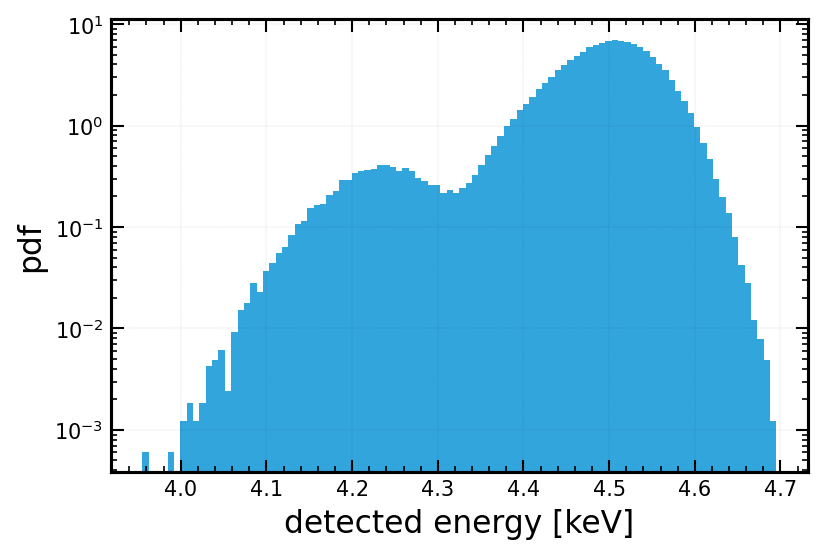

In [35]:
fig = plt.figure(dpi=150)
plt.hist(energy_detected[eff.bool_diode_hit], bins=100, density=True, alpha=0.8)
plt.xlabel('detected energy [keV]')
plt.ylabel('pdf')
plt.yscale('log')
plt.grid()
plt.show()